# 1. 导包&读入数据

In [1]:
# -*- coding: utf-8 -*-
# Author: tigflanker
# Date: 18 Dec 2018

# 导MLMF建模包 
import sys
sys.path.append(r'/home/tigflanker/python') 

import MLMF as mf

y_var = 'y_tag'

In [2]:
# 导官方包 
import numpy as np
import math
import pandas as pd 
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

/export/grid/04/home/tigflanker/env3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/export/grid/04/home/tigflanker/env3.5/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
datain = pd.read_csv(r'/export/grid/04/home/tigflanker/data/gy14_pop_features_tag_train_20190129.txt',sep='\t',encoding='utf-8',engine='python',skiprows=3)

# 2. 特征预处理

## 2.1. 数据观察

In [4]:
# 做数据质量探查
try:
    Variable_pre_exp = pd.read_csv(r'/export/grid/04/home/tigflanker/result/variable_exp_9month.csv',sep=',',encoding='utf-8',engine='python')
    Variable_pre_exp = Variable_pre_exp.rename(columns={'字段名' : 'var', '字段类型' : 'var_type', '最小最大值（字符型为长度）' : 'min_max', '0值数' : '0_n', '0值率' : '0_r',
 '唯一值数' : 'val_cate_n', '唯一值率' : 'val_cate_r', '缺失数' : 'na_n', '缺失率' : 'na_r', '众数值' : 'md_v', '众数率' : 'md_r',
 '3倍标准差极端值数' : 'ext_3', '值类数超过0.2' : 'sug_drop_cate', '值缺失超过0.6' : 'sug_drop_na'})
except:
    Variable_pre_exp, obs_miss_rate = mf.data_exp(datain, calc_obs_na=True, plt_out='/export/grid/04/home/tigflanker/result/variable_exp_full')

## 2.2. 剔除数据质量不好的变量或者不应出现在模型中的变量

In [6]:
# 剔除缺失值过多和字符型变量分类过多情况
for x in Variable_pre_exp.loc[Variable_pre_exp.sug_drop_na | Variable_pre_exp.sug_drop_cate, 'var']: # 
    try:del datain[x]
    except:pass    
Variable_pre_exp = Variable_pre_exp[(~Variable_pre_exp.sug_drop_na) & (~Variable_pre_exp.sug_drop_cate)].reset_index(drop=True).drop(['sug_drop_na', 'sug_drop_cate'], 1)

In [7]:
# 剔除无关变量
datain = datain[list(set(datain.columns) - set(['**feature**', '**feature**', '**feature**', '**feature**', '**feature**', '**feature**', '**feature**', '**feature**']))]    
# , '**feature**'

## 2.3. 哑变量处理

In [ ]:
# 说明：机器学习路线均需要处理字符型的哑变量、评分卡模型则不需要
# 此处均统一做哑变量处理

In [8]:
# 将major_trade做dummy
dummy_mapping_df, dummy_mapping_dict = mf.Dummy(datain, dummy_var = '**feature**', drop_one = False)

In [ ]:
# 查看哑变量映射字典
dummy_mapping_dict

In [3]:
# 截断点，节省数据处理时间
try:
    dummy_mapping_df = pd.read_csv(r'/export/grid/04/home/tigflanker/data/dummy_mapping_df.csv',sep=',',encoding='utf-8',engine='python')
except:
    dummy_mapping_df.to_csv('/export/grid/04/home/tigflanker/data/dummy_mapping_df.csv',index=False)
    
dt = dummy_mapping_df.dt

## 2.x. 其他操作

In [ ]:
# 定义Y
# dummy_mapping_df[y_var] = dummy_mapping_df['**feature**'].map(lambda x:1 if 1 - x > 0.489 else 0)

In [ ]:
# 查看坏样本率
# dummy_mapping_df.groupby(['dt',y_var]).pop_vender_acc_id.count()

# 3. 集成学习建模

## 3.1. XGBoost线路

### 3.1.1. XGB特征筛选

In [4]:
# 对数据集做初步划分
oot1 = dummy_mapping_df[dt == '2018-03-31']
oot2 = dummy_mapping_df[dt == '2018-04-30']
oot3 = dummy_mapping_df[dt == '2018-05-31']
oot4 = dummy_mapping_df[dt == '2018-06-30']
train_test = dummy_mapping_df[(dt != '2018-03-31') & (dt != '2018-04-30') & (dt != '2018-05-31') & (dt != '2018-06-30')]

In [ ]:
# XGB特征筛选采用Feature importance和特征PSI联合筛选，两者结果联合考量
# 用适当“宽”的参数对特征预测能力进行排序
# max_depth = 5, cv = 10, num_boost_round = 100

# 粗调参
param = {'max_depth':3
         ,'eta':0.07
         ,'silent':0
         ,'objective':'binary:logistic'
         ,'booster':'gbtree'
         ,'gama':0
         ,'min_child_weight':1
         ,'subsample':0.9
         ,'eval_metric':'auc'
         ,'early_stopping_rounds':50
        }

train_ks_list, test_ks_list = [], []
train_auc_list, test_auc_list = [], []
keep_list = set(train_test.columns)
imp_merge = pd.DataFrame([], columns=['Var'])

for k, (train, test) in enumerate(KFold(len(train_test), 5, shuffle=True, random_state=2019)):
    dtrain = xgb.DMatrix(train_test.iloc[train][list(set(train_test.columns) - set(['y_tag','dt','**feature**', '**feature**']))], label=train_test.y_tag.iloc[train])
    dtest = xgb.DMatrix(train_test.iloc[test][list(set(train_test.columns) - set(['y_tag','dt','**feature**', '**feature**']))], label=train_test.y_tag.iloc[test])

    xgb_model = xgb.train(params=param.items() ,dtrain=dtrain,num_boost_round = 50,evals=[(dtest,'test'), (dtrain,'train')])
    y_train = xgb_model.predict(dtrain)
    y_test = xgb_model.predict(dtest)
     
    trainauc = roc_auc_score(train_test.y_tag.iloc[train], y_train)
    testauc = roc_auc_score(train_test.y_tag.iloc[test], y_test)
    train_auc_list.append(trainauc)
    test_auc_list.append(testauc)
    
    feature_important_weight = xgb_model.get_score(importance_type='weight')
    weight_keys = list(feature_important_weight.keys())
    weight_values = list(feature_important_weight.values())
    feature_important_gain = xgb_model.get_score(importance_type='gain')
    gain_keys = list(feature_important_gain.keys())
    gain_values = list(feature_important_gain.values())
    feature_important_cover = xgb_model.get_score(importance_type='cover')
    cover_keys = list(feature_important_cover.keys())
    cover_values = list(feature_important_cover.values())

    imp_w = pd.DataFrame(list(zip(weight_keys, weight_values)), columns=['Var','weight'+str(k)])
    imp_g = pd.DataFrame(list(zip(gain_keys, gain_values)), columns=['Var','gain'+str(k)])
    imp_c = pd.DataFrame(list(zip(cover_keys, cover_values)), columns=['Var','cover'+str(k)])

    importance = pd.merge(pd.merge(imp_w, imp_g, how='outer', on='Var'), imp_c, how='outer', on='Var')
    imp_merge = pd.merge(imp_merge, importance, how='outer', on='Var')  # full join 
    keep_list = keep_list & set(importance.Var)

In [ ]:
print('保留特征数：', len(keep_list))
print('特征列表：', keep_list)

In [7]:
# 考量特征PSI
psi_value1 = mf.PSI(train_test, oot1)
psi_value2 = mf.PSI(train_test, oot2)
psi_value3 = mf.PSI(train_test, oot3)
psi_value4 = mf.PSI(train_test, oot4)

In [8]:
psi_merge = pd.concat([pd.Series(psi_value1.Psi.values, index=psi_value1.Var), 
                       pd.Series(psi_value2.Psi.values, index=psi_value2.Var), 
                       pd.Series(psi_value3.Psi.values, index=psi_value3.Var),
                       pd.Series(psi_value4.Psi.values, index=psi_value4.Var)], axis = 1)

In [64]:
# 综合度量，查看PSI分布，查看特征重要性分布
pd.merge(psi_merge, imp_merge, how='outer', left_index=True,right_on='Var').to_csv('/export/grid/04/home/tigflanker/result/new_y_imp_psi.csv',index=False)

### 3.1.2. 将筛选后的keep_list对数据集重新划分

In [9]:
# 机器学习路线保留特征
# 334特征，200，5 
ml_keep_list = [y_var, '**feature**', '**feature**', '**feature**']
# 86特征，100，3 
ml_keep_list = [y_var, '**feature**', '**feature**', '**feature**']
# 49特征，50, 3
# New Y, 50, 4, PSI < 0.2, 50个
ml_keep_list = [y_var, '**feature**', '**feature**', '**feature**']

ml_datain = dummy_mapping_df[ml_keep_list]
dt = dummy_mapping_df.dt
len(ml_keep_list)

50

In [10]:
#留出oot 
oot1 = ml_datain[dt == '2018-03-31']
oot2 = ml_datain[dt == '2018-04-30']
oot3 = ml_datain[dt == '2018-05-31']
oot4 = ml_datain[dt == '2018-06-30']
train_test = ml_datain[(dt != '2018-03-31') & (dt != '2018-04-30') & (dt != '2018-05-31') & (dt != '2018-06-30')]

### 3.1.3. XGB模型训练

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_test.drop([y_var], axis=1), train_test[y_var], test_size = 0.2, random_state = 2019)

In [12]:
train_test[y_var].value_counts()

0    483423
1     64404
Name: y_tag, dtype: int64

In [ ]:
# 网格搜索调参，网格搜索调参容易过拟合，不常用

clf_cv = xgb.XGBClassifier()
param_dist = {
        'n_estimators':[200, 300], # [30,50]
        'max_depth':[5, 7], #[3,5]
        'learning_rate':[0.07], #[0.01,0.05,0.1]
        'subsample':[0.9], #[0.8, 0.9]
        'colsample_bytree':[1], #[0.5, 0.6, 0.7, 0.8, 0.9],
        'scale_pos_weight':[7, 8]
        }

grid = GridSearchCV(clf_cv,param_dist,cv = 3,scoring = 'roc_auc',n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train)
clf_xgb = grid.best_estimator_  # 按照网格搜索最好case作为分类器
print(grid.best_score_)
print(clf_xgb)

# XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
#        gamma=0, learning_rate=0.07, max_delta_step=0, max_depth=9,
#        min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
#        objective='binary:logistic', reg_alpha=0, reg_lambda=1,
#        scale_pos_weight=3, seed=0, silent=True, subsample=0.9)

In [13]:
# 如参数已确定，直接训练
clf_xgb = xgb.XGBClassifier(learning_rate=0.07, max_depth=5, n_estimators=100, nthread=-1, scale_pos_weight=8).fit(X_train, y_train)

### 3.1.4. XGB模型表现

In [14]:
# AUC、KS
def roc_ks(clf = 'clf', X = 'X', y = 'y'):
    fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:,1], pos_label = 1)
    auc_score = auc(fpr, tpr)
    w = tpr - fpr
    ks_score = w.max()

    print('AUC:',round(auc_score,4))
    print(' KS:',round(ks_score,4))

roc_ks(clf = clf_xgb, X = X_train, y = y_train)
roc_ks(clf = clf_xgb, X = X_test, y = y_test)
print('----- 以下为OOT表现 -----')
roc_ks(clf = clf_xgb, X = oot1.drop([y_var], axis=1), y = oot1['y_tag'])
roc_ks(clf = clf_xgb, X = oot2.drop([y_var], axis=1), y = oot2['y_tag'])
roc_ks(clf = clf_xgb, X = oot3.drop([y_var], axis=1), y = oot3['y_tag'])
roc_ks(clf = clf_xgb, X = oot4.drop([y_var], axis=1), y = oot4['y_tag'])

AUC: 0.8498
 KS: 0.5402
AUC: 0.8419
 KS: 0.5256
----- 以下为OOT表现 -----
AUC: 0.8413
 KS: 0.531
AUC: 0.8248
 KS: 0.4942
AUC: 0.8254
 KS: 0.4995
AUC: 0.8047
 KS: 0.4659


In [15]:
# 模型预测结果OOT稳定性
mf.PSI(clf_xgb.predict_proba(X_train)[:,1], clf_xgb.predict_proba(X_test)[:,1])
mf.PSI(clf_xgb.predict_proba(X_train)[:,1], clf_xgb.predict_proba(oot1.drop([y_var], axis=1))[:,1])
mf.PSI(clf_xgb.predict_proba(X_train)[:,1], clf_xgb.predict_proba(oot2.drop([y_var], axis=1))[:,1])
mf.PSI(clf_xgb.predict_proba(X_train)[:,1], clf_xgb.predict_proba(oot3.drop([y_var], axis=1))[:,1])
mf.PSI(clf_xgb.predict_proba(X_train)[:,1], clf_xgb.predict_proba(oot4.drop([y_var], axis=1))[:,1])

PSI value: 9.113089066792531e-05
PSI value: 0.001366107022575792
PSI value: 0.034845689300212736
PSI value: 0.0321071330683274
PSI value: 0.017073504998211444


0.017073504998211444

In [18]:
# 用于绘制百分位区段，样本数及累计坏样本率

xxx = pd.DataFrame(list(zip(np.trunc(clf_xgb.predict_proba(X_test)[:,1]*100)/100, y_test.values)), columns=['p','y'])
xxx.groupby('p').agg({'p':'count','y':np.mean}).head(10)
# xxx.to_csv('/export/grid/04/home/tigflanker/result/new_y_xgb_predict.csv',index=False)

,y,p
p,,
0.03,0.000000,99
0.04,0.003610,554
0.05,0.004252,1176
0.06,0.002900,1724
0.07,0.002095,2387
0.08,0.002108,2846
0.09,0.005682,3168
0.10,0.009416,3080
0.11,0.010006,3098


/export/grid/04/home/tigflanker/env3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: tigflankerWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


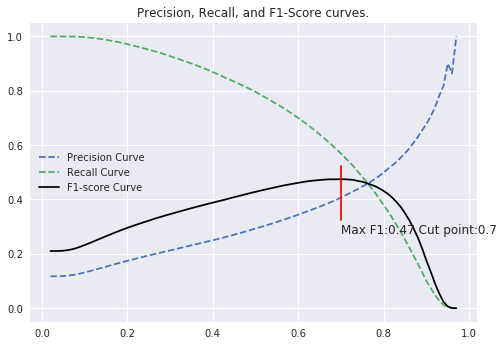

>>>>>Best cut point on MAX(F1-score):
     Cut point  Precision  Recall(TPR)     FPR  F1-score
68        0.7     0.4071        0.569  0.1104    0.4746
>>>>>Train set score:75.01%
>>>>>Test set score:74.60%


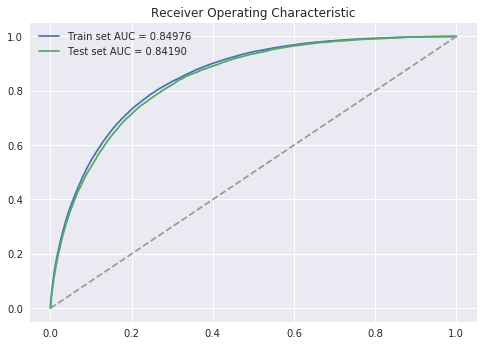

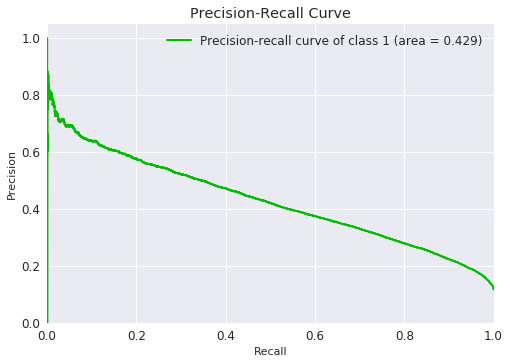

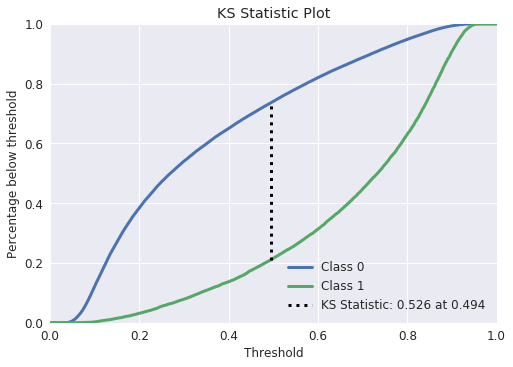

In [19]:
# 模型表现，Train-Test集
mf.Model_Performance(clf_xgb, X_train, y_train, X_test, y_test, calc_list = ['pr','roc','ks','fi','cut'], out_path = '/export/grid/04/home/tigflanker/result/new_y_perform')

In [ ]:
# 模型表现，OOT集
mf.Model_Performance(clf_xgb, oot1.drop([y_var], axis=1), oot1['y_tag'], calc_list = ['roc','ks'])
# mf.Model_Performance(clf_xgb, oot2.drop([y_var], axis=1), oot2['y_tag'], calc_list = ['roc','ks'])
# mf.Model_Performance(clf_xgb, oot3.drop([y_var], axis=1), oot3['y_tag'], calc_list = ['roc','ks'])
# mf.Model_Performance(clf_xgb, oot4.drop([y_var], axis=1), oot4['y_tag'], calc_list = ['roc','ks'])

## 3.2. Random Forest线路

In [ ]:
# 因为分类变量已经在入模之前做过处置，这里和XGBoost相比，只需要对数据集填补一次，其他套路和XGBoost基本相似

### 3.2.1. 数据集填补以及特征初筛

In [25]:
# 先对数据集进行填补
datain_imp = mf.Missing_Data_Impute(dummy_mapping_df.drop('dt', axis = 1), imp_config='imp_median')
# datain_dummyed, dummy_mapping_dict = mf.Dummy_char(datain_imp.drop('dt', axis = 1), dummy_var=['**feature**', '**feature**'], drop_one=False)

# 对数据集做初步划分
oot1 = datain_imp[dt == '2018-03-31']
oot2 = datain_imp[dt == '2018-04-30']
oot3 = datain_imp[dt == '2018-05-31']
oot4 = datain_imp[dt == '2018-06-30']
train_test = datain_imp[(dt != '2018-03-31') & (dt != '2018-04-30') & (dt != '2018-05-31') & (dt != '2018-06-30')]

In [27]:
train_ks_list, test_ks_list = [], []
train_auc_list, test_auc_list = [], []
imp_merge = pd.DataFrame(list(train_test.columns), columns=['Var'])

for k, (train, test) in enumerate(KFold(len(train_test), 5, shuffle=True, random_state=2019)):
    rf_train_X, rf_train_y = train_test.drop(['y_tag'], axis = 1).iloc[train], train_test.y_tag.iloc[train]
    rf_test_X, rf_test_y = train_test.drop(['y_tag'], axis = 1).iloc[test], train_test.y_tag.iloc[test]

    print(str(k+1)+'th fitting...')
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=9, verbose=1, n_jobs=-1).fit(rf_train_X, rf_train_y)
    y_train = rf_model.predict_proba(rf_train_X)[:,1]
    y_test = rf_model.predict_proba(rf_test_X)[:,1]
   
    fpr, tpr, thresholds = roc_curve(rf_train_y, y_train, pos_label = 1)
    auc_score = auc(fpr, tpr)
    ks_score = (tpr - fpr).max()
    train_auc_list.append(auc_score)
    train_ks_list.append(ks_score)
    
    fpr, tpr, thresholds = roc_curve(rf_test_y, y_test, pos_label = 1)
    auc_score = auc(fpr, tpr)
    ks_score = (tpr - fpr).max()
    test_auc_list.append(auc_score)
    test_ks_list.append(ks_score)
   
    feature_importance = pd.DataFrame(list(zip(train_test.columns, rf_model.feature_importances_)), columns=['Var','imp_'+str(k)])
    feature_importance = feature_importance[feature_importance['imp_'+str(k)] > 0]
    imp_merge = pd.merge(imp_merge, feature_importance, how='inner', on='Var')  # full join 

imp_merge['imp_mean'] = imp_merge.drop('Var', axis = 1).apply(np.mean, axis=1)
imp_merge['imp_std'] = imp_merge.drop('Var', axis = 1).apply(np.std, axis=1)

imp_merge = imp_merge.sort_values('imp_mean',ascending=False).reset_index(drop = True)
print('Train:', np.mean(train_auc_list), np.std(train_auc_list), np.mean(train_ks_list), np.std(train_ks_list))
print('Test:', np.mean(test_auc_list), np.std(test_auc_list), np.mean(test_ks_list), np.std(test_ks_list))
print(len(imp_merge),'features kept.')

1th fitting...


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   58.3s finished
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.4s finished


2th fitting...


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.3s finished


3th fitting...


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.3s finished


4th fitting...


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   59.1s finished
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.3s finished


5th fitting...


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.4s finished


Train: 0.852135986552 0.00043423607681 0.542405179124 0.000677845120963
Test: 0.83564586602 0.0023025012084 0.516759914548 0.0060970009446
445 features kept.


In [28]:
# 上次记录
print('Train:', np.mean(train_auc_list), np.std(train_auc_list), np.mean(train_ks_list), np.std(train_ks_list))
print('Test:', np.mean(test_auc_list), np.std(test_auc_list), np.mean(test_ks_list), np.std(test_ks_list))
print(rf_model)
print(imp_merge.head(20))
imp_merge.to_csv('/export/grid/04/home/tigflanker/result/rf_importance_new_y.csv',index=False)

# Train: 0.81181053709 0.000438104882894 0.470950608353 0.00121276902825
# Test: 0.777181686367 0.00108472376263 0.413350188677 0.00227858269434
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=11, max_features='auto', max_leaf_nodes=None,
#             min_impurity_split=1e-07, min_samples_leaf=1,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             n_estimators=200, n_jobs=-1, oob_score=False,
#             random_state=None, verbose=1, warm_start=False)

Train: 0.852135986552 0.00043423607681 0.542405179124 0.000677845120963
Test: 0.83564586602 0.0023025012084 0.516759914548 0.0060970009446
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=1, warm_start=False)
                         Var     imp_0     imp_1     imp_2     imp_3  \
0         actual_sale_amt_6m  0.062063  0.060135  0.067136  0.069757   
1            sale_ord_cnt_6m  0.058846  0.060191  0.057209  0.065932   

       imp_4  imp_mean   imp_std  
0   0.078592  0.067536  0.005945  
1   0.054858  0.059407  0.003392  


### 3.2.2. 将筛选后的keep_list对数据集重新划分

In [29]:
# 机器学习路线保留特征
rf_keep_list = [y_var, '**feature**', '**feature**', '**feature**']

ml_datain = datain_imp[rf_keep_list]
dt = dummy_mapping_df.dt
len(rf_keep_list)

48

In [30]:
#留出oot 
oot1 = ml_datain[dt == '2018-03-31']
oot2 = ml_datain[dt == '2018-04-30']
oot3 = ml_datain[dt == '2018-05-31']
oot4 = ml_datain[dt == '2018-06-30']
train_test = ml_datain[(dt != '2018-03-31') & (dt != '2018-04-30') & (dt != '2018-05-31') & (dt != '2018-06-30')]

### 3.2.3. RF模型训练

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_test.drop([y_var], axis=1), train_test[y_var], test_size = 0.2, random_state = 2019)

In [32]:
train_test[y_var].value_counts()

0    483423
1     64404
Name: y_tag, dtype: int64

In [33]:
clf_rf = RandomForestClassifier(max_depth=7, n_estimators=200, n_jobs=-1).fit(X_train, y_train)

In [ ]:
# 网格搜索调参略，详见 3.1.3

### 3.2.4. RF模型表现

In [35]:
# AUC、KS
def roc_ks(clf = 'clf', X = 'X', y = 'y'):
    fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:,1], pos_label = 1)
    auc_score = auc(fpr, tpr)
    w = tpr - fpr
    ks_score = w.max()

    print('AUC:',round(auc_score,4))
    print(' KS:',round(ks_score,4))

roc_ks(clf = clf_rf, X = X_train, y = y_train)
roc_ks(clf = clf_rf, X = X_test, y = y_test)
print('----- 以下为OOT表现 -----')
roc_ks(clf = clf_rf, X = oot1.drop([y_var], axis=1), y = oot1['y_tag'])
roc_ks(clf = clf_rf, X = oot2.drop([y_var], axis=1), y = oot2['y_tag'])
roc_ks(clf = clf_rf, X = oot3.drop([y_var], axis=1), y = oot3['y_tag'])
roc_ks(clf = clf_rf, X = oot4.drop([y_var], axis=1), y = oot4['y_tag'])

AUC: 0.8161
 KS: 0.4831
AUC: 0.8114
 KS: 0.4748
----- 以下为OOT表现 -----
AUC: 0.8299
 KS: 0.5083
AUC: 0.8107
 KS: 0.4717
AUC: 0.8127
 KS: 0.486
AUC: 0.7962
 KS: 0.4564


In [36]:
# 模型预测结果OOT稳定性

mf.PSI(clf_rf.predict_proba(X_train)[:,1], clf_rf.predict_proba(X_test)[:,1])
mf.PSI(clf_rf.predict_proba(X_train)[:,1], clf_rf.predict_proba(oot1.drop([y_var], axis=1))[:,1])
mf.PSI(clf_rf.predict_proba(X_train)[:,1], clf_rf.predict_proba(oot2.drop([y_var], axis=1))[:,1])
mf.PSI(clf_rf.predict_proba(X_train)[:,1], clf_rf.predict_proba(oot3.drop([y_var], axis=1))[:,1])
mf.PSI(clf_rf.predict_proba(X_train)[:,1], clf_rf.predict_proba(oot4.drop([y_var], axis=1))[:,1])

PSI value: 0.00010617541898123815
PSI value: 0.015499196361309779
PSI value: 0.06308072406321596
PSI value: 0.02416163139461844
PSI value: 0.013696532908853414


0.013696532908853414

In [37]:
# 用于绘制百分位区段，样本数及累计坏样本率

xxx = pd.DataFrame(list(zip(np.trunc(clf_rf.predict_proba(X_test)[:,1]*100)/100, y_test.values)), columns=['p','y'])
xxx.groupby('p').agg({'p':'count','y':np.mean}).head(10)
# xxx.to_csv('/export/grid/04/home/tigflanker/result/new_y_rf_predict.csv',index=False)

,y,p
p,,
0.02,0.005477,4747
0.03,0.018018,23587
0.04,0.035665,11552
0.05,0.040743,8934
0.06,0.056438,6361
0.07,0.071639,5081
0.08,0.087996,4307
0.09,0.100634,3786
0.10,0.098566,3348


In [ ]:
# 模型表现，Train-Test集
mf.Model_Performance(clf_rf, X_train, y_train, X_test, y_test, calc_list = ['pr','roc','ks','fi','cut'], out_path = '/export/grid/04/home/tigflanker/result/new_y_perform_rf')

In [ ]:
# 模型表现，OOT集
mf.Model_Performance(clf_rf, oot1.drop([y_var], axis=1), oot1['y_tag'], calc_list = ['roc','ks','cut'])
# mf.Model_Performance(clf_rf, oot2.drop([y_var], axis=1), oot2['y_tag'], calc_list = ['roc','ks','cut'])
# mf.Model_Performance(clf_rf, oot3.drop([y_var], axis=1), oot3['y_tag'], calc_list = ['roc','ks','cut'])
# mf.Model_Performance(clf_rf, oot4.drop([y_var], axis=1), oot4['y_tag'], calc_list = ['roc','ks','cut'])

### 3.2.x. XGBoosr和RF比较

In [ ]:
# 需要相同特征群才能进行比较
# mf.Model_Performance(clf_rf,  X_test, y_test, calibration={'Random Forest':clf_rf,'XGBoost':clf_xgb}, calc_list = [])

# 4. 评分卡路线

## 4.1. 对数据集做分箱、计算IV值

In [ ]:
# 本评分卡处理数据路线按照分箱处理，也可以走机器学习LR路线，对数据进行01标准化

In [80]:
# 分箱和计算WoE-IV
# lr_keep_list是后面特征筛选后的结果
cut_df, fa_df = mf.Cut_Merge(dummy_mapping_df[lr_keep_list], cut_way = 'ef', cut_n = 10, cut_y = y_var, calc_woe = True)
# fa_df.to_csv('/export/grid/04/home/tigflanker/result/fa_df_m9_21f.csv',index=False)

Start cutting numerical variables...
Numerical variables clear!
Calculating WoE & IV value...
!!!Notice: The value in output dataset will be transform into WoE.!!!
Final merge step...


## 4.2. 特征筛选阶段

### 4.2.1 预先划分数据集

In [81]:
# 按照dt做切割
# datain_imp = mf.Missing_Data_Impute(dummy_mapping_df.drop('dt', axis = 1), imp_config='imp_median') # 标准化路线

lr_oot1 = cut_df[dt == '2018-03-31']
lr_oot2 = cut_df[dt == '2018-04-30']
lr_oot3 = cut_df[dt == '2018-05-31']
lr_oot4 = cut_df[dt == '2018-06-30']
lr_train_test = cut_df[(dt != '2018-03-31') & (dt != '2018-04-30') & (dt != '2018-05-31') & (dt != '2018-06-30')]

### 4.2.x. 标准化流程

In [ ]:
# 01标准化（做过WOE转换后的数据原理无需再做标准化）
cols = list(lr_train_test.columns)
cols.remove(y_var)

scaler = preprocessing.MinMaxScaler().fit(lr_train_test[cols])
lr_train_test_norm = pd.DataFrame(scaler.transform(lr_train_test[cols]) , columns = cols)
lr_oot1_norm = pd.DataFrame(scaler.transform(lr_oot1[cols]) , columns = cols)
lr_oot2_norm = pd.DataFrame(scaler.transform(lr_oot2[cols]) , columns = cols)
lr_oot3_norm = pd.DataFrame(scaler.transform(lr_oot3[cols]) , columns = cols)

### 4.2.2. 分别计算Corr、VIF、PSI

/export/grid/04/home/tigflanker/env3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: tigflankerWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


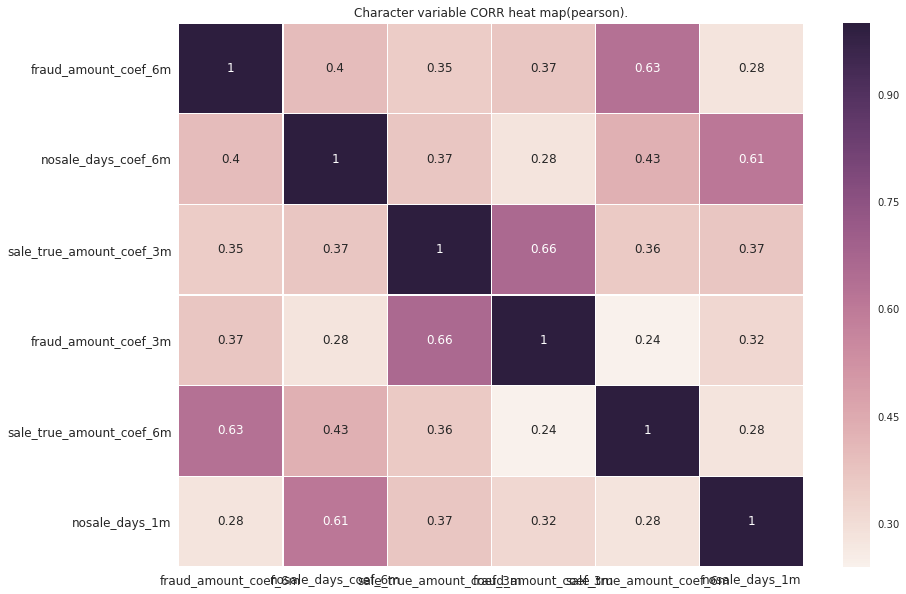

In [82]:
# 计算Corr和VIF
corr_df = mf.Corr_Vif(lr_train_test[lr_keep_list], corr_plt_filter=0.6) 

In [83]:
# 特征稳定性PSI
psi_value1 = mf.PSI(lr_train_test, lr_oot1)
psi_value2 = mf.PSI(lr_train_test, lr_oot2)
psi_value3 = mf.PSI(lr_train_test, lr_oot3)
psi_value4 = mf.PSI(lr_train_test, lr_oot4)

In [84]:
psi_merge = pd.concat([pd.Series(psi_value1.Psi.values, index=psi_value1.Var), 
                       pd.Series(psi_value2.Psi.values, index=psi_value2.Var), 
                       pd.Series(psi_value3.Psi.values, index=psi_value3.Var)], axis = 1)

In [85]:
pd.merge(psi_merge, corr_df, how='outer', left_index=True,right_on='Var').to_csv('/export/grid/04/home/tigflanker/result/corr_vif_psi_new_y.csv',index=False)

### 4.2.3. 再利用LR中的L1正则化筛减

In [ ]:
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_train_test, lr_train_test[y_var], test_size = 0.2, random_state = 2018)

In [ ]:
clf_lr_l1 = LogisticRegression(penalty='l1', C=0.4).fit(lr_X_train, lr_y_train)

In [ ]:
print(sum(clf_lr_l1.coef_[0] != 0))
keep_list = pd.Series(clf_lr_l1.coef_[0], index=[lr_X_train.columns.values])
keep_list.index[keep_list != 0]

### 4.2.4. 将筛选后的keep_list对数据集重新划分

In [63]:
# L1 + 标准化 + 去除相关性
lr_keep_list = [y_var, '**feature**', '**feature**', '**feature**', '**feature**', '**feature**', '**feature**', '**feature**', '**feature**', '**feature**']
len(lr_keep_list)

10

In [86]:
# 按照dt做切割
cut_df = mf.Missing_Data_Impute(dummy_mapping_df[lr_keep_list], imp_config='imp_median')

lr_oot1 = cut_df[dt == '2018-03-31']
lr_oot2 = cut_df[dt == '2018-04-30']
lr_oot3 = cut_df[dt == '2018-05-31']
lr_oot4 = cut_df[dt == '2018-06-30']
lr_train_test = cut_df[(dt != '2018-03-31') & (dt != '2018-04-30') & (dt != '2018-05-31') & (dt != '2018-06-30')]

本次填补规则如下： {}


## 4.3. LR模型训练

In [87]:
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_train_test.drop(y_var, axis = 1), lr_train_test[y_var], test_size = 0.2, random_state = 2018)

In [88]:
clf_lr_l2 = LogisticRegression(penalty='l2').fit(lr_X_train, lr_y_train)

In [ ]:
coef = pd.DataFrame(list(zip(lr_X_train.columns, clf_lr_l2.coef_[0])), columns=['Var','coef'])
coef = coef[coef.coef != 0].sort_values('coef',ascending=False).reset_index(drop = True)
# coef.to_csv('/home/tigflanker/python_script/coef.csv',encoding='utf-8',index=False)
coef

## 4.4. 模型表现

In [90]:
# AUC、KS
def roc_ks(clf = 'clf', X = 'X', y = 'y'):
    fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:,1], pos_label = 1)
    auc_score = auc(fpr, tpr)
    w = tpr - fpr
    ks_score = w.max()

    print('AUC:',round(auc_score,4))
    print(' KS:',round(ks_score,4))

roc_ks(clf = clf_lr_l2, X = lr_X_train, y = lr_y_train)
roc_ks(clf = clf_lr_l2, X = lr_X_test, y = lr_y_test)
print('----- 以下为OOT表现 -----')
roc_ks(clf = clf_lr_l2, X = lr_oot1.drop([y_var], axis=1), y = lr_oot1['y_tag'])
roc_ks(clf = clf_lr_l2, X = lr_oot2.drop([y_var], axis=1), y = lr_oot2['y_tag'])
roc_ks(clf = clf_lr_l2, X = lr_oot3.drop([y_var], axis=1), y = lr_oot3['y_tag'])
roc_ks(clf = clf_lr_l2, X = lr_oot4.drop([y_var], axis=1), y = lr_oot4['y_tag'])

AUC: 0.768
 KS: 0.4255
AUC: 0.77
 KS: 0.4265
----- 以下为OOT表现 -----
AUC: 0.7901
 KS: 0.4669
AUC: 0.7652
 KS: 0.4259
AUC: 0.7561
 KS: 0.4224
AUC: 0.7423
 KS: 0.3941


In [ ]:
mf.Model_Performance(clf_lr_l2, lr_X_train, lr_y_train, lr_X_test, lr_y_test, calc_list=['pr', 'roc', 'ks'])

In [ ]:
mf.Model_Performance(clf_lr_l2, lr_oot1.drop(y_var, axis = 1), lr_oot1['y_tag'], calc_list = ['roc','ks'])

## 4.5. PDO打分

In [93]:
# PDO评分转换
fa_df, Basic_score = mf.PDO_Score(lr_X_train, lr_y_train, clf_lr_l2, fa_df)

In [100]:
# PDO打分
PDO_Score_out = mf.PDO_Score_Convert(lr_oot1, fa_df, Basic_score = Basic_score)

Columns not match, please check. This time use intersection set replace.


In [101]:
PDO_Score_out.head(10)

,**feature**,**feature**,**feature**,**feature**,**feature**,**feature**,**feature**,**feature**,**feature**,PDO_Score_Convert
0,4.501793,1.210570,-2.971608,0.000790,19.983187,0.686610,7.551542,-5.420507,-0.388756,564.803472
1,7.801743,6.993036,1.679519,0.000790,32.399938,0.638606,16.803450,1.134440,-0.388756,606.712618
2,4.501793,-23.202845,-2.971608,-0.000060,-56.398293,0.185217,-15.258606,-5.420507,-0.388756,440.696186
3,7.801743,11.415412,1.617558,-0.000683,32.399938,0.686610,16.803450,3.981048,-0.388756,613.966172
4,4.501793,1.210570,1.617558,0.000790,20.398432,0.421241,16.962122,3.981048,-0.388756,588.354649
5,4.501793,-10.937065,-2.971608,-0.000060,25.431384,0.638606,-2.170095,1.134440,-0.388756,554.888490
6,9.517123,6.993036,2.364082,-0.000683,33.362164,0.686610,16.962122,0.283676,-0.388756,609.429224
7,4.760884,1.210570,-2.971608,-0.000648,25.431384,0.686610,-15.258606,-5.420507,0.243713,548.331644
8,11.132963,10.541952,1.617558,-0.000060,25.431384,0.638606,14.032615,4.323917,-0.388756,606.980030
9,4.501793,-23.202845,2.364082,-0.000648,19.983187,0.638606,-2.170095,1.134440,0.243713,543.142085


In [102]:
fa_df.head(10)

,Bins,Var,Binn,bads,N,bad rate,Woe,Iv,Iv_rank,Score
0,"(-inf, 0.741]",**feature**,0,19449,98292,19.79%,0.504685,0.113592,8.0,-22.733011
1,"(0.741, 0.88]",**feature**,1,11576,97975,11.82%,-0.105694,0.113592,8.0,4.760884
2,"(0.88, 0.923]",**feature**,2,9322,99083,9.41%,-0.360425,0.113592,8.0,16.234987
3,"(0.923, 0.948]",**feature**,3,9423,97856,9.63%,-0.334744,0.113592,8.0,15.078183
4,"(0.948, 0.963]",**feature**,4,10609,101823,10.42%,-0.247158,0.113592,8.0,11.132963
5,"(0.963, 0.972]",**feature**,5,10477,97382,10.76%,-0.211285,0.113592,8.0,9.517123
6,"(0.972, 0.979]",**feature**,6,11713,105240,11.13%,-0.173203,0.113592,8.0,7.801743
7,"(0.979, 0.985]",**feature**,7,12226,102953,11.88%,-0.099942,0.113592,8.0,4.501793
8,"(0.985, 0.991]",**feature**,8,12628,90078,14.02%,0.090632,0.113592,8.0,-4.082421
9,"(0.991, inf]",**feature**,9,19670,89844,21.89%,0.632465,0.113592,8.0,-28.488711


# 5. 模型及表格保存

In [ ]:
from sklearn.externals import joblib

In [ ]:
# 保存模型
joblib.dump((clf_xgb, Variable_pre_exp, obs_miss_rate),'/export/grid/04/home/tigflanker/model/model_table.model')

In [ ]:
joblib.dump((clf_lr_l1),'/export/grid/04/home/tigflanker/model/clf_lr_l1.model')

In [ ]:
joblib.dump((clf_lr_l2),'/export/grid/04/home/tigflanker/model/clf_lr_l2.model')

In [ ]:
importances = pd.DataFrame(list(zip(X_train.columns, clf_xgb.feature_importances_)), columns=['Var','imp'])

In [ ]:
importances.to_csv('/export/grid/04/home/tigflanker/result/importances.csv',index=False)

In [ ]:
X_train.columns

In [ ]:
mf.MLMP(clf_xgb, X_train, y_train, X_test, y_test)